# Electric Production Forecasting



# 1. Business Understanding
## 1.1 Overview

With their recent successful real estate investment in California, our client Homegates Property Group seeks to expand their listings in the state of New York, which happens to be the state with the most Fortune 500 company headquarters in the United States and the world. Our client believes the trends and contributing factors that they saw in California, especially the continued job growth will also positively impact the home values in New York. The team is looking for recommendations on top 5 zipcodes to invest in New York, and this analysis will also provide them with short-term vs. long-term investment decisions.

## 1.2 Problem Statement

The goal of this analysis is to identify the top 5 zipcodes for our client to invest in New York. The team is not quite familiar with the East Coast real estate market, and therefore, has asked to take risk factor into consideration. The results from this analysis will provide them with the forecast of next 10 year mean house values in the top 5 zipcodes as well as expected ROI in 1 year, 3 years, 5 years, and 10 years.

## 1.3 Objective

 1. To determine the expected ROI yield in 1 year, 3 years, 5 years, and 10 years.
 2. To identify the top 5 zipcodes for our client to invest in New York based on the ROI yields.
 
## 1.4 Metric of Success



# 2. Data Understanding
## 2.1 Data Overview
The dataset for this analysis comes from Zillow Research, which contains the median home sales prices in 14,723 individual zipcodes from April 1996 through April 2018. 
Each row represents a unique zip code indexed with RegioinID, and contains location info and median housing sales prices for each month.

## 2.2 Data Description

RegionID: Unique index, 58196 through 753844

RegionName: Unique Zip Code, 1001 through 99901

City: City in which the zip code is located

State: State in which the zip code is located

Metro: Metropolitan Area in which the zip code is located

CountyName: County in which the zip code is located

SizeRank: Numerical rank of size of zip code, ranked 1 through 14723

1996-04 through 2018-04: refers to the median housing sales values for April 1996 through April 2018, that is 265 data points of monthly data for each zip code



## 2.3 Load the Data/Filtering for Chosen Zipcodes

In [1]:
#import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
np.random.seed(123)
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from matplotlib import rcParams
from statsmodels.tsa.stattools import adfuller


In [2]:
#load the data into a dataframe and preview
df = pd.read_csv('data/electric_production.csv')
df.head()

,DATE,IPG2211A2N
0,1939-01-01,3.3335
1,1939-02-01,3.3590
2,1939-03-01,3.4353
3,1939-04-01,3.4607
4,1939-05-01,3.4607


In [3]:
df.tail()

,DATE,IPG2211A2N
1001,2022-06-01,104.5230
1002,2022-07-01,115.5747
1003,2022-08-01,114.2425
1004,2022-09-01,100.5098
1005,2022-10-01,92.3498


In [4]:
#general description of the data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        1006 non-null   object 
 1   IPG2211A2N  1006 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


* The data type for date column is object and this should be changed to datetime format.
* The column name for IPG2211A2N column is not clear.

In [5]:
#checking the rows and colums
df.shape

(1006, 2)

The data has 1006 rows and 2 columns

In [6]:
#check for missing values
df.isnull().sum()

DATE          0
IPG2211A2N    0
dtype: int64

There are no missing values

In [7]:
#check for duplicates
df.duplicated().sum()

0

There are no dulpicates in our data

# 3. Data Preparation
#### Validity

In [8]:
#change the column name
df.rename(columns={'IPG2211A2N':'energy_production(quads)', 'DATE':'date'}, inplace=True)

In [9]:
#change date column data type to datetime
df['date'] = pd.to_datetime(df['date'])

In [10]:
#setting the date as index
df.set_index('date', inplace=True)

In [11]:
df.dtypes

energy_production(quads)    float64
dtype: object

Since the data spans for a very long period of time i.e 1939 to 2022, we decided to slice the data and work with more recent data

In [12]:
#slice the data from the year 1990
new_df = df['1990':]
#preview the new data
new_df.head()

,energy_production(quads)
date,
1990-01-01,83.3773
1990-02-01,76.2628
1990-03-01,72.3211
1990-04-01,66.4534
1990-05-01,65.0260


# Step 3: EDA and Visualization

### Histogram and Density plot

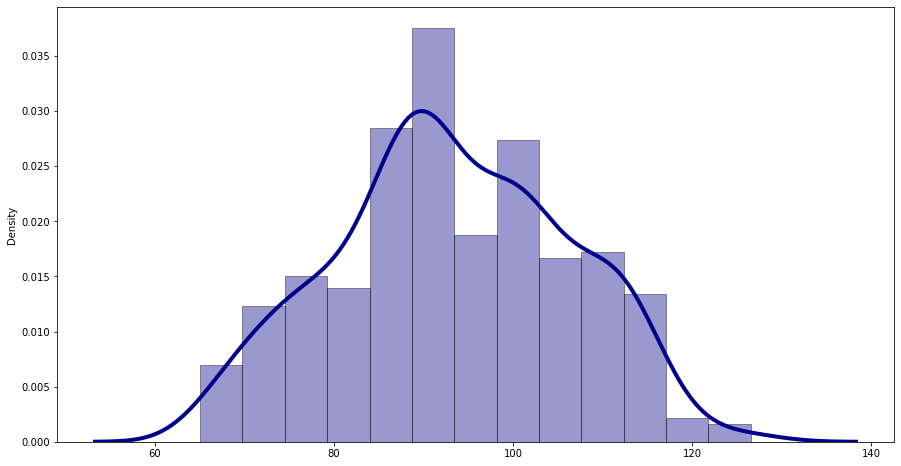

In [13]:
rcParams['figure.figsize'] = 15,8
sns.distplot(new_df, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}
             )
plt.xlabel('')
plt.show()

from the plot above the data is somewhat normally distributed


### Time series line plot

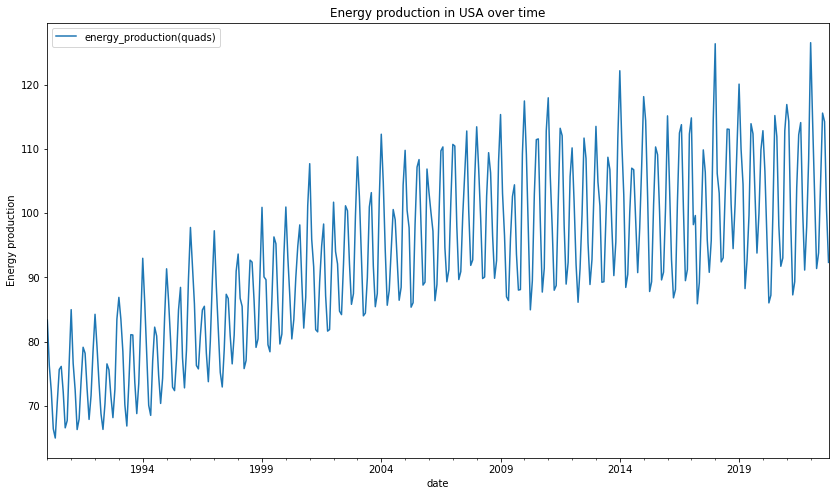

In [14]:
new_df.plot(figsize=(14,8))
plt.ylabel('Energy production')
plt.title('Energy production in USA over time')
plt.show()

We have observed a periodic and upward trend from 1990 to 2009 since the energy production increases over time and then after 2009 we have seasonal variation in our data.

<AxesSubplot:xlabel='date'>

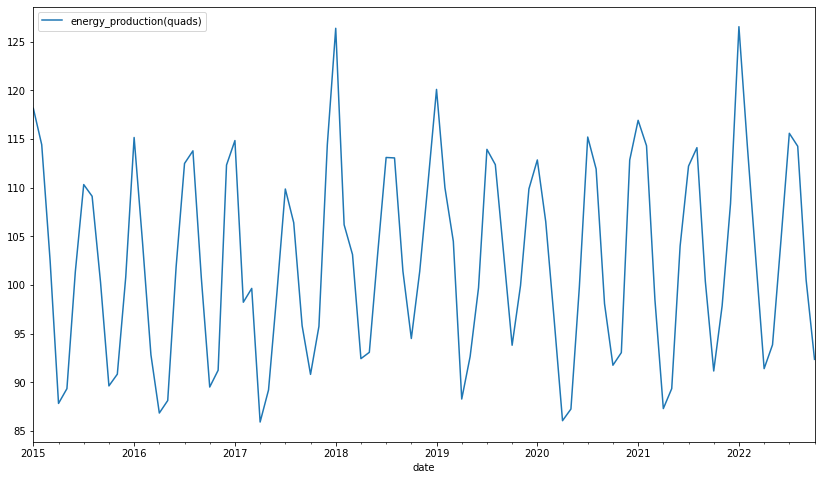

In [15]:
df_2015 =  df['2015':]
df_2015.plot(figsize=(14,8))

### Grouping and visualizing time series data

In [16]:
#Use pandas grouper to group values using annual frequency
# year_groups = new_df['2010':].groupby(pd.Grouper(freq ='A'))
# len(year_groups['date'])

#year_groups.plot(figsize=(14, 8),subplots=True, legend=True)

# #Create a new DataFrame and store yearly values in column
# s 
# us_annual = pd.DataFrame()

# for yr, group in year_groups:
#     us_annual[yr.year] = group.values.ravel()
    
# #Plot the yearly groups as subplots
# us_annual.plot(figsize = (13,8), subplots=True, legend=True);

### Checking for Trends
We can see that that there is an overall increasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. Let's reconfirm this here using both rolling statistics and the Dickey-Fuller test

### Rolling Statistics

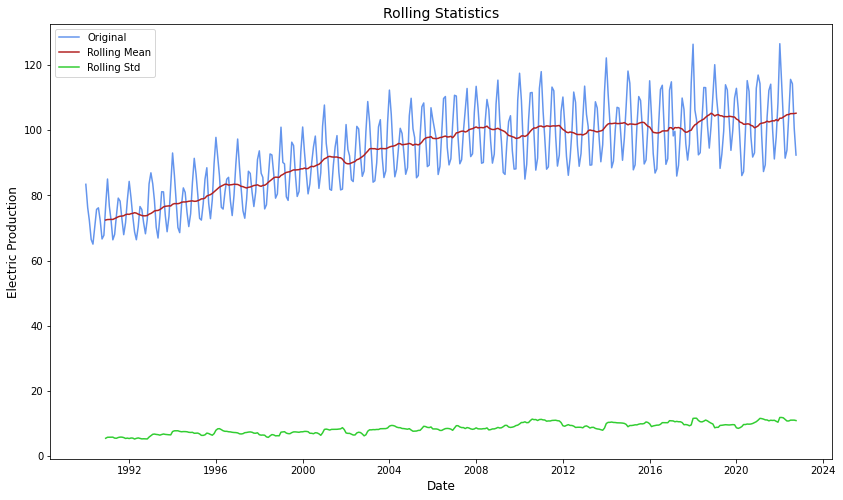

In [17]:
rolling_mean = new_df.rolling(window=12, center=False).mean()
rolling_std = new_df.rolling(window=12, center=False).std()
plt.figure(figsize = (14,8))
plt.plot(new_df, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size  = 12)
plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()

Though the variation in standard deviation is small, the mean is increasing with time and thus, this is not a stationary series.

In [18]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(new_df, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.040830
p-value                          0.268962
#Lags Used                      16.000000
Number of Observations Used    377.000000
Critical Value (1%)             -3.447815
Critical Value (5%)             -2.869237
Critical Value (10%)            -2.570870
dtype: float64


The null-hypothesis for the test is that the time series is not stationary. The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

# Step 4: Reshape from Wide to Long Format

In [19]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# Step 5: ARIMA Modeling

# Step 6: Interpreting Results